In [1]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="*", force=True))
import pickle
import gzip
import copy
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torchvision
# from curriculum_deeplab.data_parameters import DataParamMode
import torchio as tio

import matplotlib.pyplot as plt
from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import visualize_seg
from curriculum_deeplab.mindssc import mindssc

from pathlib import Path

import wandb
import random
import glob
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  ---------
   1  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.5(495.29.05)
   2  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.5(495.29.05)
   3  NVIDIA GeForce RTX 2080 Ti     0 %    9269 MiB  11.5(495.29.05)  nicke
   0  NVIDIA GeForce RTX 2080 Ti     0 %    2575 MiB  11.5(495.29.05)  schneider

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   1  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0
1.9.0a0+gitdfbd030
8204
NVIDIA GeForce RTX 2080 Ti


In [2]:
def in_notebook():
    try:
        get_ipython().__class__.__name__
        return True
    except NameError:
        return False

if in_notebook:
    THIS_SCRIPT_DIR = os.path.abspath('')
else:
    THIS_SCRIPT_DIR = os.path.dirname(os.path.realpath(__file__))
print(f"Running in: {THIS_SCRIPT_DIR}")

Running in: /share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab


In [91]:
file_paths = [
    # '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/crimson-oath-956_fold0_epx39/train_label_snapshot.pth',
    # '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/_clean-morning-918_fold0_epx39/train_label_snapshot.pth'
    # '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/balmy-wildflower-1109_fold0_epx39/train_label_snapshot.pth'
    '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/laced-totem-1240_fold0_epx39/train_label_snapshot.pth',
    '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/comfy-yogurt-1241_fold0_epx39/train_label_snapshot.pth',
    '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/dashing-sponge-1237_fold0_epx39/train_label_snapshot.pth',
    '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/summer-bush-1239_fold0_epx39/train_label_snapshot.pth',
]

hues = {
    'laced': (185, 68, 188),
    'comfy': (221, 147, 6),
    'dashing': (146, 208, 80),
    'summer': (230, 117, 49),
}
# file_paths = glob.glob('./data/output/**/*.pth')
dp_tensors = []
dice_tensors = []

for _path in file_paths:
    data = torch.load(_path)
    if not 'disturb_flags' in data: continue
    dp_mean_weight = data['data_parameters'].squeeze().detach().cpu()
    disturb_flags = data['disturb_flags'] 
    d_ids = data['d_ids'] 
    dataset_idxs = data['dataset_idxs'] 
    _2d_labels = data['labels']
    _2d_modified_labels = data['modified_labels']
    _2d_predictions = data['train_predictions']
    print(f"{'/'.join(_path.split('/')[-2:])} has {len(dp_mean_weight)} parameters.")

    _2d_labels = _2d_labels.to_dense()
    _2d_modified_labels = _2d_modified_labels.to_dense()
    _2d_predictions = _2d_predictions.to_dense()

    gt_sum = _2d_modified_labels.sum((-2,-1))
    pp_sum = _2d_predictions.sum((-2,-1)).squeeze(1).cpu()
    rgt_sum =  _2d_labels.sum((-2,-1)).cpu()
    intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
    dice = 2*intersect/(rgt_sum+gt_sum+1)

    all_elems = \
        dict(
            disturbed_bool_vect = torch.tensor(disturb_flags).float(),
            gt_sum=gt_sum, 
            dice=dice, 
            pp_sum=pp_sum,
            sqrt_gt_sum=np.sqrt(gt_sum),
            log_gt_sum=np.log(gt_sum+1)+1, # this seems to be right
            e_log_gt_sum=np.log(gt_sum+np.exp(1))+np.exp(1),
            inv_e_log_gt_sum=1/(np.log(gt_sum+np.exp(1))+np.exp(1)),
        )
    
    for name, metric in all_elems.items():
        print(name, np.corrcoef(dp_mean_weight.cpu().detach(), metric.detach())[0,1])
    for name, metric in all_elems.items():
        if name in ['dice', 'disturbed_bool_vect']: continue
        
        print(f"Corr coeff DP_weight/dice {np.corrcoef(dp_mean_weight.detach(), dice.detach())[0,1]:.2f} vs. DP_reweight/dice with {name} {np.corrcoef((dp_mean_weight/(metric+1e-6)).cpu().detach(), dice.detach())[0,1]:.2f}")
    reweighted = dp_mean_weight/(all_elems['e_log_gt_sum'])

    # sel_idxs = reweighted<100
    sel_idxs = range(len(reweighted))
    srtd_reweighted = reweighted[sel_idxs]
    srtd_dice_reweighted = dice[sel_idxs]

    srtd = sorted(zip(srtd_reweighted, srtd_dice_reweighted))
    srtd_reweighted, srtd_dice_reweighted = zip(*srtd)
    srtd_reweighted, srtd_dice_reweighted = torch.stack(srtd_reweighted), torch.stack(srtd_dice_reweighted)
    dp_tensors.append(dp_mean_weight)
    dice_tensors.append(dice)

laced-totem-1240_fold0_epx39/train_label_snapshot.pth has 3600 parameters.
disturbed_bool_vect -0.5182557303693589
gt_sum 0.43259919282499765
dice 0.570652563082461
pp_sum 0.3563006482254954
sqrt_gt_sum 0.3948206684356493
log_gt_sum 0.28591081521306283
e_log_gt_sum 0.2950446076070039
inv_e_log_gt_sum -0.2483947010043055
Corr coeff DP_weight/dice 0.57 vs. DP_reweight/dice with gt_sum 0.42
Corr coeff DP_weight/dice 0.57 vs. DP_reweight/dice with pp_sum 0.37
Corr coeff DP_weight/dice 0.57 vs. DP_reweight/dice with sqrt_gt_sum 0.42
Corr coeff DP_weight/dice 0.57 vs. DP_reweight/dice with log_gt_sum 0.50
Corr coeff DP_weight/dice 0.57 vs. DP_reweight/dice with e_log_gt_sum 0.58
Corr coeff DP_weight/dice 0.57 vs. DP_reweight/dice with inv_e_log_gt_sum 0.51
comfy-yogurt-1241_fold0_epx39/train_label_snapshot.pth has 3600 parameters.
disturbed_bool_vect -0.4613193014824245
gt_sum -0.6637086919764642
dice -0.2757625698824753
pp_sum -0.6990615295569335
sqrt_gt_sum -0.7318121427276556
log_gt_sum -

In [123]:
from matplotlib.colors import ListedColormap
def hue_map(target_hue: tuple):
    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(.8, target_hue[0]/256, N)
    vals[:, 1] = np.linspace(.8, target_hue[1]/256, N)
    vals[:, 2] = np.linspace(.8, target_hue[2]/256, N)
    return ListedColormap(vals)

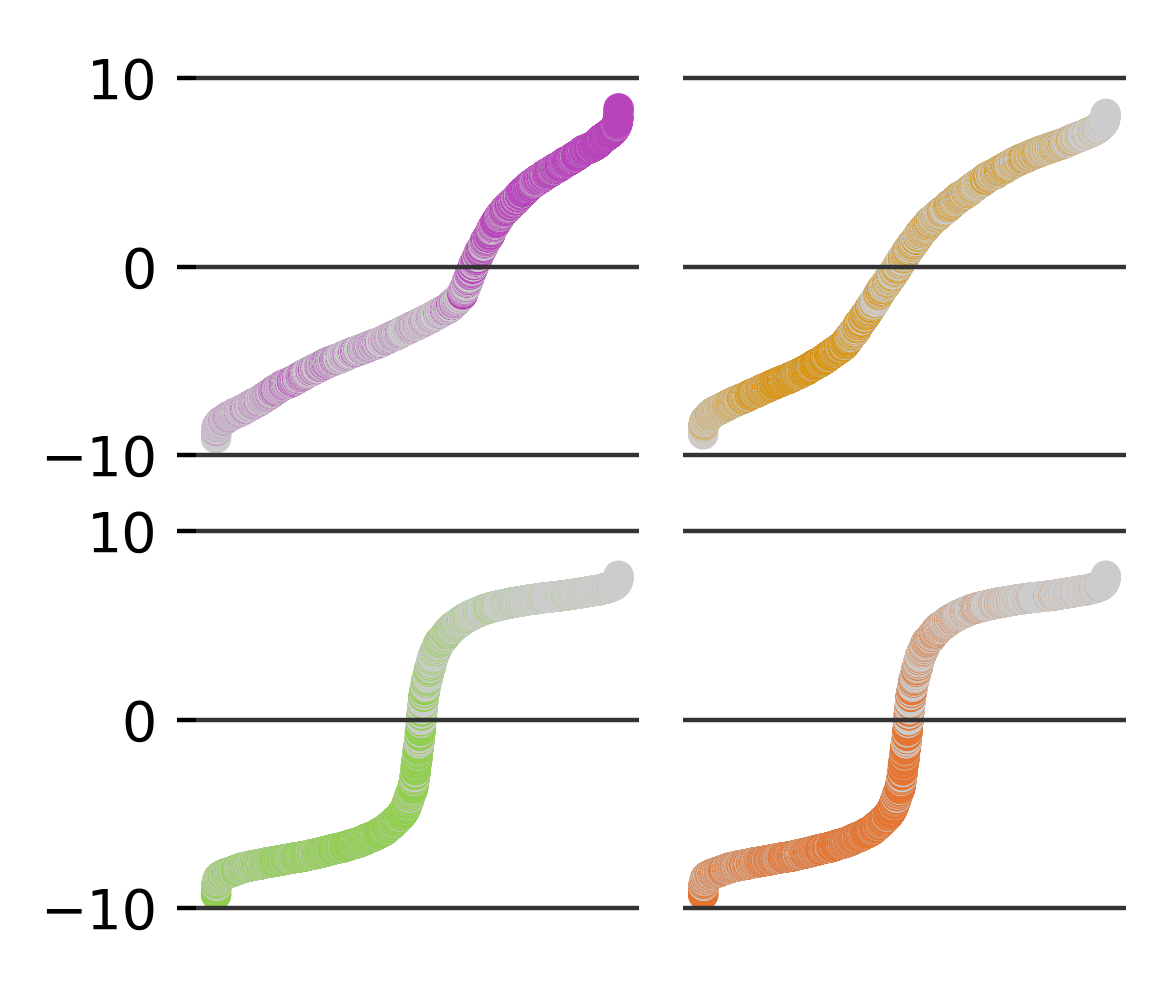

In [150]:
def setup_ax(cur_ax):
    cur_ax.set_ylim(*y_lims)
    cur_ax.grid(axis='y', color=(.2,.2,.2))
    cur_ax.spines['top'].set_visible(False)
    cur_ax.spines['right'].set_visible(False)
    cur_ax.spines['bottom'].set_visible(False)
    cur_ax.spines['left'].set_visible(False)

# Show weights and weights with compensation
fig, _ = plt.subplots(2,2, figsize=(3, 3), dpi=400)
plt.subplots_adjust(wspace=.1, hspace=0)
y_lims = (-12, 12)
axs = fig.axes
plt_data = dp_tensors[0].cpu().numpy()
plt_color = dice_tensors[0].cpu().numpy()
cur_ax = axs[0]
setup_ax(cur_ax)


sc1 = cur_ax.scatter(range(len(plt_data)), plt_data, c=plt_color,s=20, vmax=1., cmap=hue_map(hues['laced']));
cur_ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt_data = dp_tensors[1].cpu().numpy()
plt_color = dice_tensors[1].cpu().numpy()
cur_ax = axs[1]
setup_ax(cur_ax)

# sc2 = cur_ax.scatter( 
#     plt_data, plt_color, c=plt_color,s=20, cmap=hue_map(hues['comfy']));

sc3 = cur_ax.scatter(range(len(plt_data)), plt_data, c=plt_color,s=20, cmap=hue_map(hues['comfy']));
cur_ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
cur_ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt_data = dp_tensors[2].cpu().numpy()
plt_color = dice_tensors[2].cpu().numpy()
cur_ax = axs[2]
setup_ax(cur_ax)
sc3 = cur_ax.scatter(range(len(plt_data)), plt_data, c=plt_color,s=20, cmap=hue_map(hues['dashing']), vmax=1.);
cur_ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt_data = dp_tensors[2].cpu().numpy()
plt_color = dice_tensors[2].cpu().numpy()
cur_ax = axs[3]
setup_ax(cur_ax)
sc4 = cur_ax.scatter(range(len(plt_data)), plt_data, c=plt_color,s=20, cmap=hue_map(hues['summer']), vmax=1);
cur_ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
cur_ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
# fig.colorbar(sc4, cax=cbar_ax)

# plt.title(f"{'/'.join(_path.split('/')[-2:])}")
plt.show()

In [127]:
print(gt_sum[-20:])

print(dp_mean_weight[-20:])
dp_mean_weight[-20:]/(1+np.exp(1))
# (np.log(gt_sum+np.exp(1))+np.exp(1))

print(len(dp_mean_weight))
print(len(gt_sum))

print(reweighted[-20:])


tensor([3204, 4176, 6956, 6108, 6200, 8548, 7248, 4900, 7320, 7504, 7224, 2624,
        7124, 8444, 7724, 4692, 7220, 5364, 4700, 8860])
tensor([7.4896, 7.5072, 7.5295, 7.5402, 7.5892, 7.6131, 7.6196, 7.6741, 7.6897,
        7.6952, 7.6985, 7.7238, 7.7608, 7.7692, 7.8504, 7.9069, 7.9437, 7.9816,
        8.1801, 8.4841])
3600
3600
tensor([0.6940, 0.6790, 0.6510, 0.6593, 0.6628, 0.6467, 0.6565, 0.6842, 0.6619,
        0.6610, 0.6634, 0.7292, 0.6696, 0.6607, 0.6727, 0.7077, 0.6846, 0.7059,
        0.7321, 0.7185])


In [ ]:
def interpolate_sample(b_image=None, b_label=None, scale_factor=1.,
                       yield_2d=False):
    if yield_2d:
        scale = [scale_factor]*2
        im_mode = 'bilinear'
    else:
        scale = [scale_factor]*3
        im_mode = 'trilinear'

    if b_image is not None:
        b_image = F.interpolate(
            b_image.unsqueeze(1), scale_factor=scale, mode=im_mode, align_corners=True,
            recompute_scale_factor=False
        )
        b_image = b_image.squeeze(1)

    if b_label is not None:
        b_label = F.interpolate(
            b_label.unsqueeze(1).float(), scale_factor=scale, mode='nearest',
            recompute_scale_factor=False
        ).long()
        b_label = b_label.squeeze(1)

    return b_image, b_label
selected_weight = reweighted
data = zip(selected_weight, d_ids, _2d_labels, _2d_modified_labels, _2d_predictions)


samples_sorted = sorted(data, key=lambda tpl: tpl[0])
(dp_weightss, d_idss, _2d_lbl, _2d_ml, _2d_p) = zip(*samples_sorted)

overlay_text_list = [f"id:{d_id} gwd:{instance_p.item():.2f}" \
    for d_id, instance_p in zip(d_idss, dp_weightss)]

visualize_seg(in_type="batch_2D",
    img=interpolate_sample(b_label=torch.stack(_2d_lbl), scale_factor=.5, yield_2d=True)[1].unsqueeze(1),
    seg=interpolate_sample(b_label=4*torch.stack(_2d_p).squeeze(1), scale_factor=.5, yield_2d=True)[1],
    ground_truth=interpolate_sample(b_label=torch.stack(_2d_ml), scale_factor=.5, yield_2d=True)[1],
    crop_to_non_zero_seg=False,
    alpha_seg = .5,
    alpha_gt = .5,
    n_per_row=70,
    overlay_text=overlay_text_list,
    annotate_color=(0,255,255),
    file_path="out_reweight.png",
)

In [ ]:
torch.save(
    {
        'reweighted_weigths': sg_reweighted,
        'd_ids': d_ids 
    }, 
    'fixed_weights.pth'
)


In [ ]:
correction = \
    [
        1.0,
        1/(1+gt_sum).numpy(), 
        1/(1+np.sqrt(gt_sum)).numpy(),
        1/np.log(gt_sum+gt_sum.max().sqrt()).numpy(),
    ]

for crr in correction:
    print(np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy()*crr, dice)[0,1])


In [ ]:
import glob
import pandas as pd
corrs = {}
def get_corr_coeff(inp):
    return np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy(), inp)[0,1]

for pth in glob.glob('./data/output/**/*.pth'):
    print(pth)
    data = torch.load(pth)
    dp_mean_weight, *_, d_ids, dataset_idxs, _2d_labels, _2d_modified_labels = data
    gt_sum = _2d_modified_labels.sum((-2,-1))
    pp_sum = _2d_labels.sum((-2,-1))
    intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
    dice = 2*intersect/(pp_sum+gt_sum)
    all_elems = dict(
            gt_sum=get_corr_coeff(gt_sum),
            intersect=get_corr_coeff(intersect),
            pp_sum=get_corr_coeff(pp_sum),
            sqrt=get_corr_coeff(np.sqrt(gt_sum)),
            log=get_corr_coeff(np.log(gt_sum+gt_sum.max().sqrt())), # this seems to be right
            dice=get_corr_coeff(dice)
    )
    corrs[pth.split('/')[-2]] = all_elems
    # break
df = pd.DataFrame(corrs)
df.to_csv('pd.csv')
print(df)
